In [3]:
import os
from posixpath import join
import paramiko
from scp import SCPClient
import shutil

run_id = 1
jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
# connect with ssh


First analyze the letter frequencies in books across the eras. As performance is not relevant now, the job will be executed with 1 reducer, using combiner.
We hypotize that the input files are already in the input folder in hdfs, in /user/hadoop/letter_analysis/input/.

In [3]:
""" ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')
root_dir = '/user/hadoop/historical_analysis'

# run the job for each file
for txt_file in os.listdir('../resources/historical_analysis/input'):
    print(f'Processing {txt_file}')
    input_dir = join(root_dir, 'input', txt_file)
    output_dir = join(root_dir, f'output_{run_id}', txt_file.split('.')[0])
    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                             f'{input_dir} {output_dir}/count {output_dir}/freq 1 inmappercombiner')
    print(stderr.read().decode('utf-8'))
    print(stdout.read().decode('utf-8'))

# copy the output to local
stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal /user/hadoop/historical_analysis/output_{run_id} .')
print(stderr.read().decode('utf-8'))

if not os.path.exists(f'../resources/historical_analysis/output_{run_id}'):
    os.mkdir(f'../resources/historical_analysis/output_{run_id}')
    
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', '../resources/historical_analysis/', recursive=True)

# remove the output
ssh.exec_command(f'rm -r output_{run_id}')
scp.close()
ssh.close() """

" ssh = paramiko.SSHClient()\nssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())\nssh.connect('10.1.1.124', username='hadoop', password='ubuntu')\nroot_dir = '/user/hadoop/historical_analysis'\n\n# run the job for each file\nfor txt_file in os.listdir('../resources/historical_analysis/input'):\n    print(f'Processing {txt_file}')\n    input_dir = join(root_dir, 'input', txt_file)\n    output_dir = join(root_dir, f'output_{run_id}', txt_file.split('.')[0])\n    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '\n                                             f'{input_dir} {output_dir}/count {output_dir}/freq 1 inmappercombiner')\n    print(stderr.read().decode('utf-8'))\n    print(stdout.read().decode('utf-8'))\n\n# copy the output to local\nstdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal /user/hadoop/historical_analysis/output_{run_id} .')\nprint(stderr.read().decode('utf-8'))\n\nif not o

After that we can analyze the output files.

../resources/historical_analysis/output_0
             a         b         c         d         e         f         g  \
1294  0.111057  0.006691  0.042903  0.043161  0.130910  0.007840  0.016282   
1321  0.107435  0.007410  0.051659  0.037205  0.120249  0.012763  0.018223   
1350  0.104108  0.006215  0.043551  0.038871  0.134355  0.009838  0.016675   
1483  0.130420  0.010505  0.045051  0.036890  0.119230  0.013003  0.021084   
1516  0.115783  0.009256  0.047854  0.037156  0.117086  0.013442  0.022996   
1518  0.108213  0.009105  0.051026  0.033731  0.123542  0.012682  0.017431   
1620  0.108867  0.009621  0.041098  0.039288  0.120334  0.013744  0.025107   
1769  0.094251  0.007932  0.047601  0.035772  0.112259  0.013973  0.021577   
1788  0.115295  0.008470  0.033842  0.038579  0.106704  0.013609  0.027358   
1827  0.114707  0.009738  0.046425  0.037303  0.120642  0.010520  0.017327   
1832  0.112681  0.009165  0.045616  0.038201  0.121263  0.010446  0.018957   
1835  0.109532  0.0085

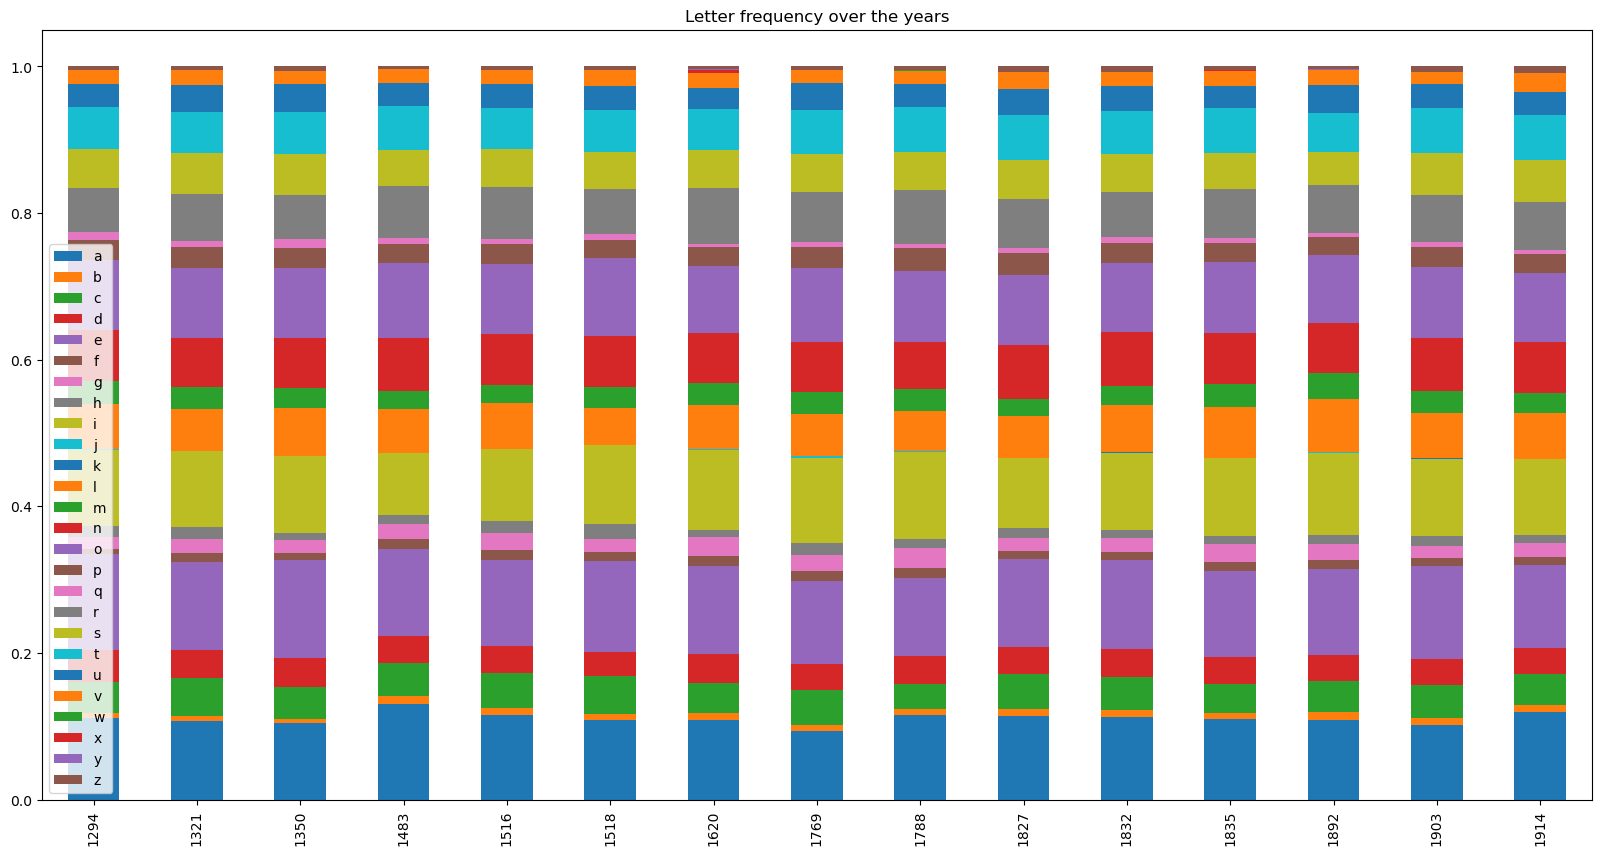

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

run_id = 0

directory = f'../resources/historical_analysis/output_{run_id}'
print(directory)

years = []
for filename in os.listdir(directory):
    year = filename.split('.')[0]
    years.append(year)

df = pd.DataFrame(index=years, columns=[])

for year in years:
    freq_per_year = []
    filepath = f'{directory}/{year}/freq/part-r-00000'
    with open(filepath, 'r') as f:
        for line in f:
            letter, freq = line.strip().split('\t')
            freq = float(freq)
            df.loc[year, letter] = freq
print(df)

df.plot( kind='bar', stacked=True, title='Letter frequency over the years', figsize=(20, 10))

performance analysis

In [5]:
""" import string
import random
# Dimensioni dei file in bytes
sizes = [10 * 1024, 1 * 1024 * 1024, 100 * 1024 * 1024, 1 * 1024 * 1024 * 1024]
chunk_size = 100  # Dimensione del chunk in bytes

# Nomi dei file
file_dir = "../resources/performance_analysis/input"
filenames = [os.path.join(file_dir, "file_10KB.txt"), 
             os.path.join(file_dir, "file_1MB.txt"), 
             os.path.join(file_dir, "file_100MB.txt"), 
             os.path.join(file_dir, "file_1GB.txt")]

# Genera una stringa di lettere casuali
def generate_random_string(length):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))

for size, filename in zip(sizes, filenames):
    print(f"Generating {filename}...")
    with open(filename, 'w') as f:
        for _ in range(size // chunk_size):
            f.write(generate_random_string(chunk_size))
            f.write('\n')
        remaining = size % chunk_size
        if remaining:
            f.write(generate_random_string(remaining))
    print(f"File {filename} generated successfully.") """

' import string\nimport random\n# Dimensioni dei file in bytes\nsizes = [10 * 1024, 1 * 1024 * 1024, 100 * 1024 * 1024, 1 * 1024 * 1024 * 1024]\nchunk_size = 100  # Dimensione del chunk in bytes\n\n# Nomi dei file\nfile_dir = "../resources/performance_analysis/input"\nfilenames = [os.path.join(file_dir, "file_10KB.txt"), \n             os.path.join(file_dir, "file_1MB.txt"), \n             os.path.join(file_dir, "file_100MB.txt"), \n             os.path.join(file_dir, "file_1GB.txt")]\n\n# Genera una stringa di lettere casuali\ndef generate_random_string(length):\n    letters = string.ascii_letters\n    return \'\'.join(random.choice(letters) for i in range(length))\n\nfor size, filename in zip(sizes, filenames):\n    print(f"Generating {filename}...")\n    with open(filename, \'w\') as f:\n        for _ in range(size // chunk_size):\n            f.write(generate_random_string(chunk_size))\n            f.write(\'\n\')\n        remaining = size % chunk_size\n        if remaining:\n     

In [5]:
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')
root_dir = '/user/hadoop/performance_analysis'
methods = ['combiner', 'inmappercombiner']
n_reducers = 3


# try all the combinations of methods and reducers
for method in methods:
    for i in range(1, n_reducers+1):
        for txt_file in os.listdir('../resources/performance_analysis/input'):
            print(f'Processing {txt_file} with {method} and {i} reducers')
            input_dir = join(root_dir, 'input', txt_file)
            output_dir = join(root_dir, f'output_{run_id}_{method}_{i}', txt_file.split('.')[0])
            ssh.exec_command(f'mkdir -p output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}')

            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                                     f'{input_dir} {output_dir}/count {output_dir}/freq {i} {method} '
                                                     f'> log.txt 2>&1')
            print(stderr.read().decode('utf-8'))
            
            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal {output_dir} output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}' )
            print(stderr.read().decode('utf-8'))
            stdin, stdout, stderr = ssh.exec_command(f'mv log.txt output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}/log.txt')
            print(stderr.read().decode('utf-8'))
            
        # create the output directory in project resources
        if not os.path.exists(f'../resources/performance_analysis/output_{run_id}_{method}_{i}'):
            os.mkdir(f'../resources/performance_analysis/output_{run_id}_{method}_{i}')

        # move the output to local machine
        scp = SCPClient(ssh.get_transport())
        scp.get(f'output_{run_id}_{method}_{i}', '../resources/performance_analysis/', recursive=True)
        
        # remove the output directory from virtual machine
        stdin, stdout, stderr = ssh.exec_command(f'rm -r output_{run_id}_{method}_{i}')
        print(stderr.read().decode('utf-8'))

scp.close()
ssh.close()

Processing 100MB.txt with combiner and 1 reducers

2024-06-20 09:36:12,105 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-20 09:36:12,271 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false


Processing 10KB.txt with combiner and 1 reducers

2024-06-20 09:36:59,986 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-20 09:37:00,160 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false


Processing 1GB.txt with combiner and 1 reducers

2024-06-20 09:48:42,351 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-20 09:48:42,529 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false


Processing

Socket exception: Connessione in corso interrotta forzatamente dall'host remoto (10054)


     10KB     1MB     100MB        1GB
1  1410.0  3390.0  131080.0  1173670.0
2  2060.0  4260.0  132580.0  1200290.0
3  2560.0  4970.0  140400.0  1202600.0
     10KB     1MB    100MB       1GB
1  1150.0  2220.0  38760.0  365970.0
2  1900.0  2720.0  39360.0  368950.0
3  2340.0  3680.0  41080.0  371650.0
                    10KB     1MB    100MB       1GB
combiner          1260.0  2780.0  84270.0  662410.0
inmappercombiner  1160.0  1930.0  26170.0  261440.0


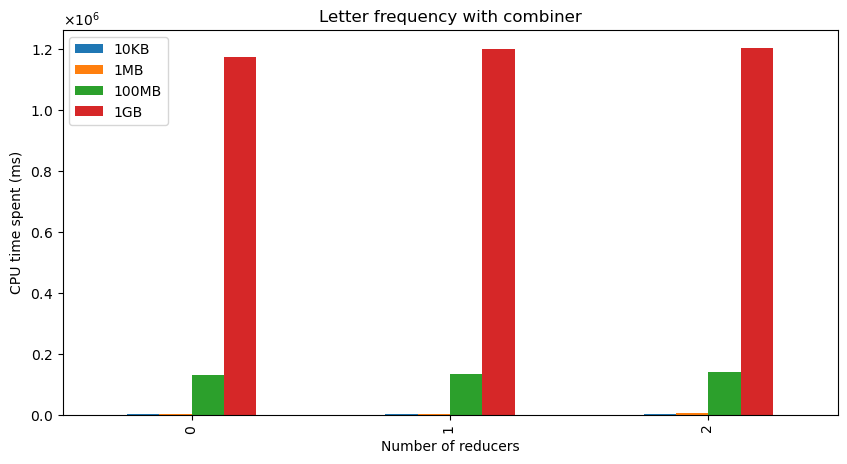

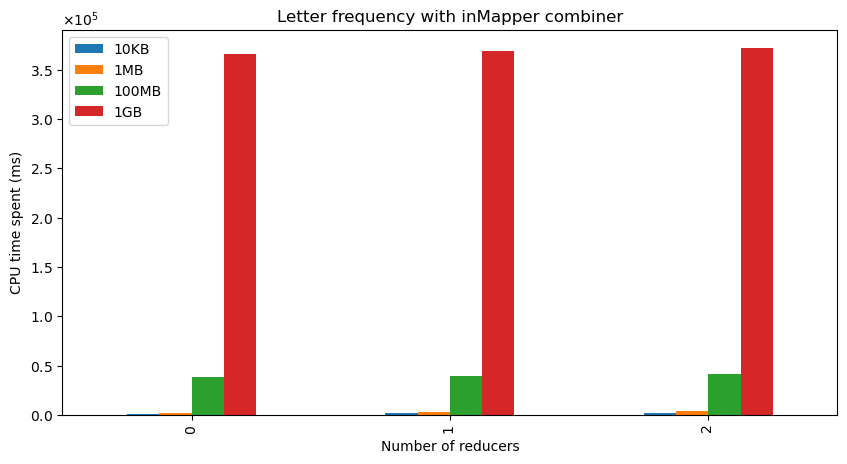

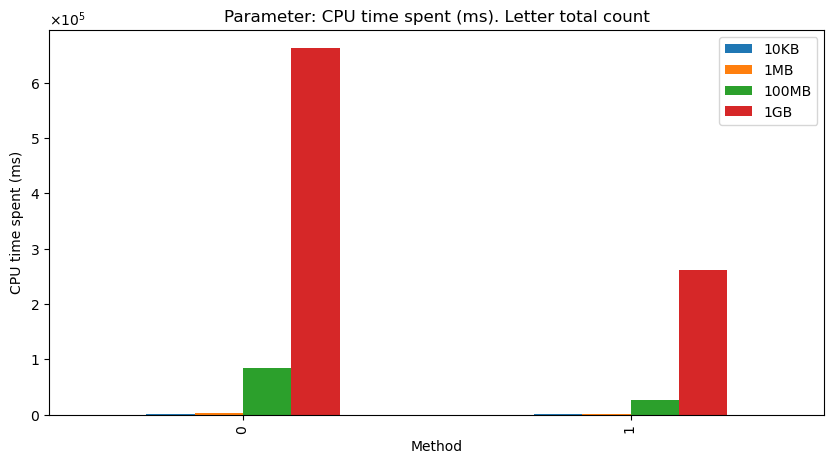

In [21]:
from matplotlib.ticker import ScalarFormatter

run_id = 1

parameters_list = [
    "CPU time spent (ms)", 
    ]
methods = ['combiner', 'inmappercombiner']
dim = ['10KB', '1MB', '100MB', '1GB']
n_reducers = 3

for params in parameters_list:
    freq_comb_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    freq_inmap_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    count_df = pd.DataFrame(index=methods, columns=dim)
    for method in methods:
        for i in range(1, n_reducers+1):
            for dim_directory in os.listdir(f'../resources/performance_analysis/output_{run_id}_{method}_{i}'):
                log_file = f'../resources/performance_analysis/output_{run_id}_{method}_{i}/{dim_directory}/log.txt'
                is_total_count = True
                with open(log_file, 'r') as f:
                    for line in f:
                        if params in line:
                            if is_total_count:
                                count_df.loc[method, dim_directory] = float(line.split('=')[1])
                                is_total_count = False
                            else:
                                if method == 'combiner':
                                    freq_comb_df.loc[i, dim_directory] = float(line.split('=')[1])
                                else:
                                    freq_inmap_df.loc[i, dim_directory] = float(line.split('=')[1])
                                is_total_count = True            
    print(freq_comb_df)
    print(freq_inmap_df)
    print(count_df)

    # Plot for freq_comb_df
    ax1 = freq_comb_df.plot(kind='bar', title='Letter frequency with combiner', figsize=(10, 5), xlabel="Number of reducers", ylabel=f'{params}')
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    # for p in ax1.patches:
    #     ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    # Plot for freq_inmap_df
    ax2 = freq_inmap_df.plot(kind='bar', title='Letter frequency with inMapper combiner', figsize=(10, 5), xlabel="Number of reducers", ylabel=f'{params}')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    # for p in ax2.patches:
    #     ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    # Plot for count_df
    ax3 = count_df.plot(kind='bar', title=f'Parameter: {params}. Letter total count', figsize=(10, 5), xlabel="Method", ylabel=f'{params}')
    ax3.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax3.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax3.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    # for p in ax3.patches:
    #     ax3.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()
